# **Importation des packages**

In [21]:
import sys
import os
import json
import math
import random
import shutil
import unicodedata
import re
import requests
import numpy as np
import pandas as pd
import PIL
from PIL import Image, ImageFile, ExifTags
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import tree, datasets, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Perceptron
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
from SPARQLWrapper import SPARQLWrapper, JSON

# **Collecte de données**

In [2]:
endpoint_url = "https://query.wikidata.org/sparql"

# Requete Wikidata récupérant les monuments en France
query = """SELECT DISTINCT ?monument ?monumentLabel ?image {
  ?monument wdt:P31 wd:Q4989906;
            wdt:P17 wd:Q142;
            wdt:P18 ?image.
 SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
LIMIT 100"""

# Fonction pour exécuter la requête SPARQL et récupérer les résultats au format JSON
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

array = []
results = get_results(endpoint_url, query)

# Extraction des données pertinentes des résultats et les ajouter à la liste
for result in results["results"]["bindings"]:
    array.append(
        (
            result["monumentLabel"]["value"],
            result["image"]["value"],
        )
    )
dataframe = pd.DataFrame(array, columns=["monument", "image"])
dataframe = dataframe.astype(
    dtype={"monument": "<U200", "image": "<U200"}
)

# Fonction pour télécharger une image à partir de son URL
def download_image(url):
    try:
        headers = {"User-Agent": "Mozilla/5.0"}
        request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
        
        if request.status_code == 200:
            os.makedirs("images", exist_ok=True)
            
            extension = url.split(".")[-1]
            
            # Créer le nom de fichier avec un numéro unique
            filename = f"{dataframe.monument[download_image.image_count]}.{extension}"
            download_image.image_count += 1
            
            filepath = os.path.join("images", filename)
            
            with open(filepath, "wb") as image_file:
                request.raw.decode_content = True
                shutil.copyfileobj(request.raw, image_file)
            
            # Normaliser et nettoyer le nom de fichier
            cleaned_filename = clean_and_normalize_filename(filename)
            os.rename(filepath, os.path.join("images", cleaned_filename))
            
            print(f"L'image a été téléchargée avec succès : {cleaned_filename}")
        
        return None
    
    except Exception as e:
        print(f"Une erreur s'est produite : {str(e)}")
        return None

def clean_and_normalize_filename(filename):
    # Normaliser les caractères Unicode
    normalized_filename = unicodedata.normalize('NFKD', filename).encode('ASCII', 'ignore').decode('utf-8')
    # Remplacer les caractères non autorisés par des tirets
    cleaned_filename = re.sub(r'[<>:"/\\|?*]', '-', normalized_filename)
    return cleaned_filename

download_image.image_count = 0
dataframe.image.apply(download_image)


L'image a été téléchargée avec succès : Q24930537.jpg
L'image a été téléchargée avec succès : Pyramide de Saint-Quentin.JPG
L'image a été téléchargée avec succès : Pyramide des Chartreux.JPG
L'image a été téléchargée avec succès : Table du Grand Maitre.jpg
L'image a été téléchargée avec succès : Joan of Arc memorial of Bonsecours.jpg
L'image a été téléchargée avec succès : Monument a Charles-Emmanuel II de Savoie.jpg
L'image a été téléchargée avec succès : Monument allemand de Flaucourt.jpg
L'image a été téléchargée avec succès : Monument funeraire de Pierre-Victor Loth.jpg
L'image a été téléchargée avec succès : Monument de la Decouverte du Charbon.JPG
L'image a été téléchargée avec succès : Monument funeraire du chasseur Marin Gousset.jpg
L'image a été téléchargée avec succès : Monument a Emile Basly.jpg
L'image a été téléchargée avec succès : Table du Roi.jpg
L'image a été téléchargée avec succès : Column to Armed Peace.JPG
L'image a été téléchargée avec succès : Monument to the Fla

0     None
1     None
2     None
3     None
4     None
      ... 
95    None
96    None
97    None
98    None
99    None
Name: image, Length: 100, dtype: object

# **Étiquetage et annotation**

In [22]:

# Dictionnaire pour convertir les codes RGB en noms de couleurs
color_names = {
    (0, 0, 0):          'Noir',
    (255, 255, 255):    'Blanc',
    (255, 255, 0):      'Jaune',
    (255, 165, 0):      'Orange',
    (148, 0, 211):      'Violet',
    (139, 69, 19):      'Marron',
    (255, 20, 147):     'Rose',
    (255, 0, 0):        'Rouge',
    (0, 255, 0):        'Vert',
    (0, 0, 255):        'Bleu',
    (245, 245, 220):    'Beige',
    (144, 238, 144):    'Vert clair',
    (0, 255, 255):      'Cyan'
}
def get_color_name(rgb):
    min_dist        = float('inf')
    closest_color   = None

    rgb_array = np.array(rgb)
    # Parcourir chaque couleur dans le dictionnaire
    for color_rgb, color_name in color_names.items():
        color_rgb_array     = np.array(color_rgb)
        dist                = np.linalg.norm(rgb_array - color_rgb_array)

        # Mettre à jour la couleur la plus proche si une couleur plus proche est trouvée
        if dist < min_dist:
            min_dist        = dist
            closest_color   = color_name

    return closest_color

In [23]:
# Limite la taille de fichier pour éviter les erreurs de décompression et choisi le dossier contenant les images
ImageFile.LOAD_TRUNCATED_IMAGES = True
image_files = os.listdir("images")
chemin_fichier_json = "metadata.json"

metadata_list = []

# Fonction pour générer un tag automatique basé sur la couleur dominante de l'image
def color_tag(color_name):
    if color_name == 'Bleu':
        return '#beau ciel bleu'
    elif color_name in ['Vert', 'Vert clair']:
        return '#belle verdure'
    elif color_name == 'Noir':
        return '#obscure'
    elif color_name in ['Rose', 'Violet', 'Orange', 'Jaune']:
        return '#coloré'
    elif color_name  in  ['Gris', 'Marron']:
        return '#pierre sympa'
    elif color_name in ['Rouge', 'Beige', 'Blanc']:
        return '#vibrant'
    
# Fonction pour sauvegarder la liste des metadonnées dans un fichier JSON
def save_metadata(metadata_list):
    with open(chemin_fichier_json, "w", encoding='utf-8') as outfile:
     json.dump(metadata_list, outfile, indent=4, ensure_ascii=False, default=str)

# Fonction pour récupérer le premier nom du titre de l'image (pour le 2e tag)
def get_first_noun(file_name):
    # Liste des mots de liaison à ignorer
    stop_words = ['de', 'du', 'des', 'le', 'la', 'les', 'un', 'une', 'au', 'aux']
    words = file_name.split()
    # Parcourir les mots et trouver le premier nom commun
    for word in words:
        if word.lower() not in stop_words:
            return word.lower()

# Parcourir les images dans le dossier
for file in image_files:
    filepath = os.path.join("images", file)
    image = Image.open(filepath)
    exif_data = image.getexif()
    
    # recuperation des donnees exif
    if exif_data:
        for tag, value in exif_data.items():
            if (tag in TAGS):
                if (TAGS[tag] == 'DateTime'):
                    year = value[0:4]
                    hour = value[11:13]
                if (TAGS[tag] == 'Model'):
                    camera = value
        length = image.width
        height = image.height

    # récupération des couleurs dominantes de l'image en utilisant MiniBatchKMeans
    if (image.mode == 'RGB'):
    
        numarray = np.array(image.getdata(), np.uint8)
        cluster_count = 3

        clusters = MiniBatchKMeans(n_clusters=cluster_count, n_init=2)
        clusters.fit(numarray)

        npbins = np.arange(0, cluster_count + 1)
        histogram = np.histogram(clusters.labels_, bins=npbins)
        labels = np.unique(clusters.labels_)

        for k in range(cluster_count):
            if (math.ceil(clusters.cluster_centers_[k][0])) == (math.ceil(clusters.cluster_centers_[k][1])) == (math.ceil(clusters.cluster_centers_[k][2])):
                couleur1="Noir"
                couleur2="Blanc"
                couleur3="Gris"
            else:
                # 1re couleur dominante
                if k == 1:
                    couleur1 = get_color_name((math.ceil(clusters.cluster_centers_[k][0]),
                        math.ceil(clusters.cluster_centers_[k][1]),
                        math.ceil(clusters.cluster_centers_[k][2]),
                    ))
                elif k == 2 :
                # 2eme couleur dominante
                    couleur2 = get_color_name((math.ceil(clusters.cluster_centers_[k][0]),
                        math.ceil(clusters.cluster_centers_[k][1]),
                        math.ceil(clusters.cluster_centers_[k][2]),
                    ))
                else:
                # 3eme couleur dominante
                    couleur3 = get_color_name((math.ceil(clusters.cluster_centers_[k][0]),
                        math.ceil(clusters.cluster_centers_[k][1]),
                        math.ceil(clusters.cluster_centers_[k][2]),
                    ))

        color_tag_text = color_tag(couleur1)
        common_noun_tag = get_first_noun(file)
    
        # Extraire les métadonnées de l'image
        metadata = {
            'file_name': file,
            'format': image.format,
            'mode': image.mode,
            'height' : height,
            'length' : length,
            'couleur1': couleur1,
            'couleur2': couleur2,
            'couleur3': couleur3,
            "year": year,
            "hour": hour,
            'favorite': False,
            'tags': [color_tag_text, common_noun_tag],
        }

        metadata_list.append(metadata)

save_metadata(metadata_list)        

# **Visualisation des donnees**

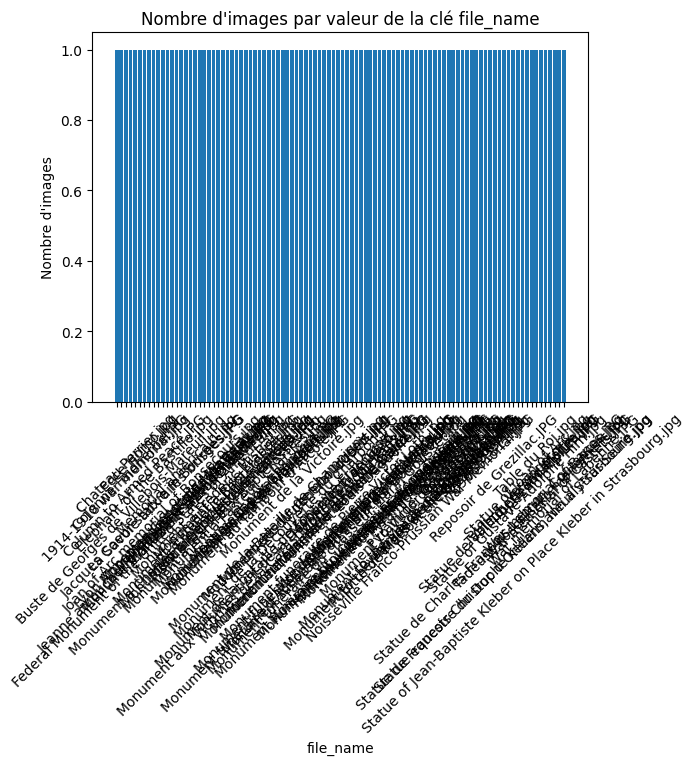

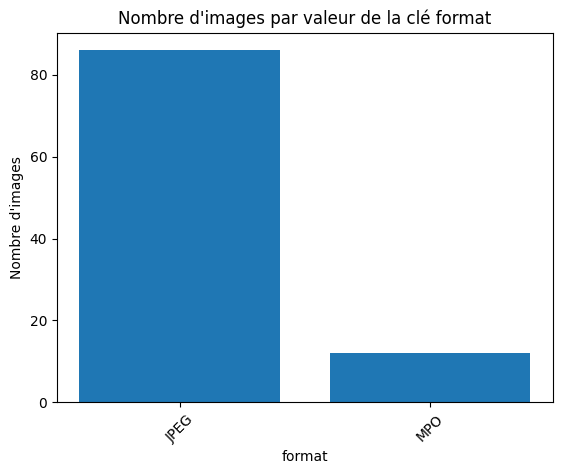

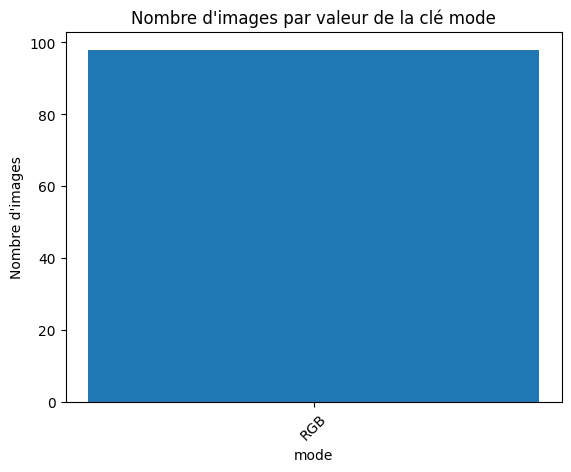

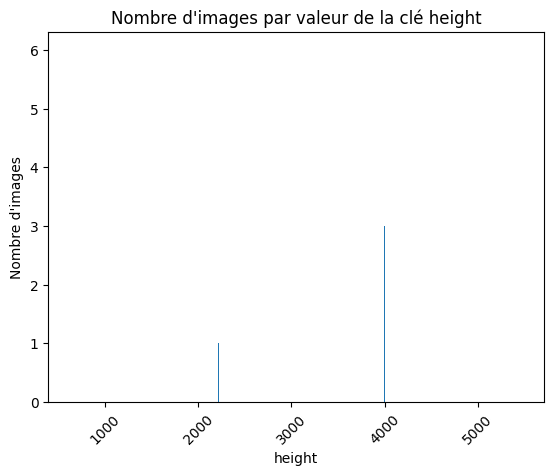

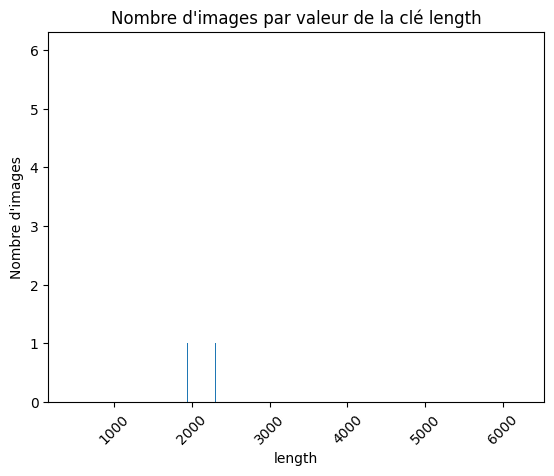

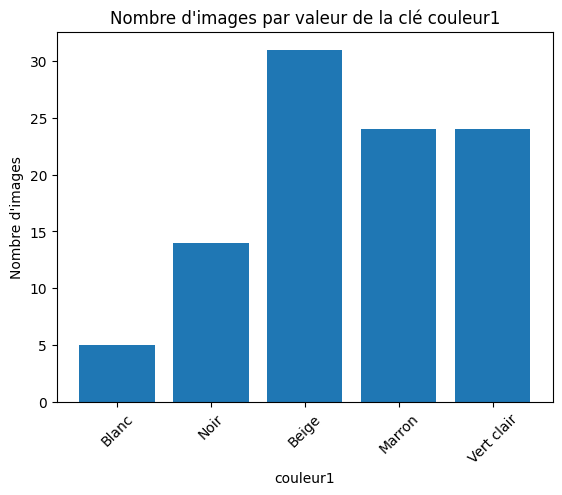

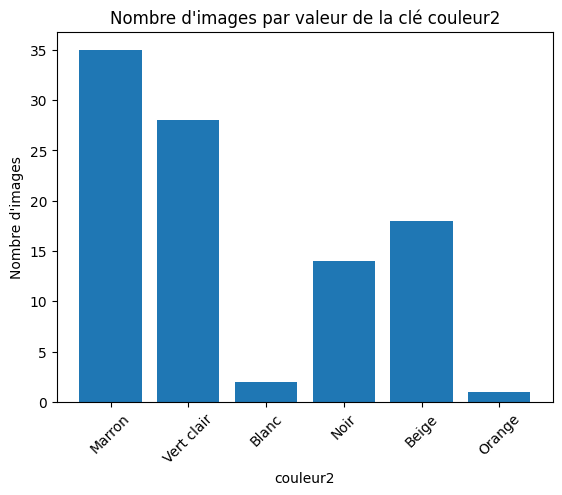

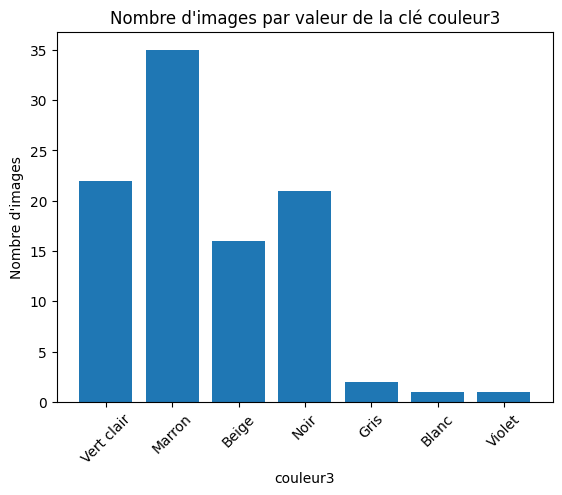

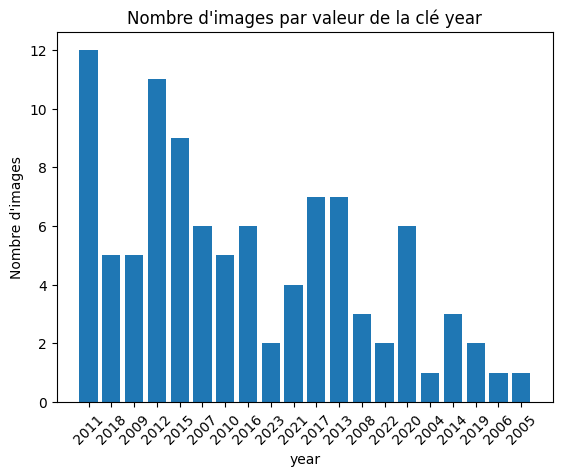

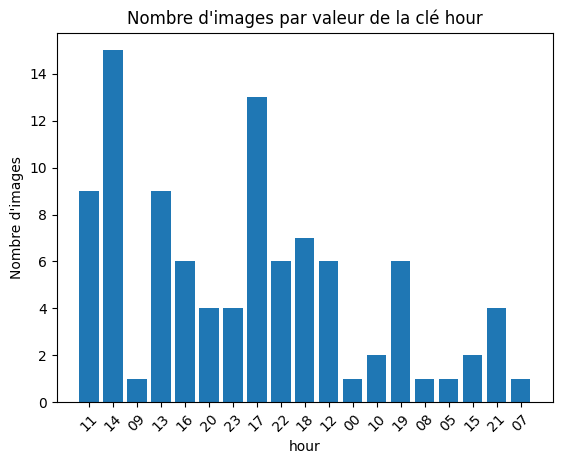

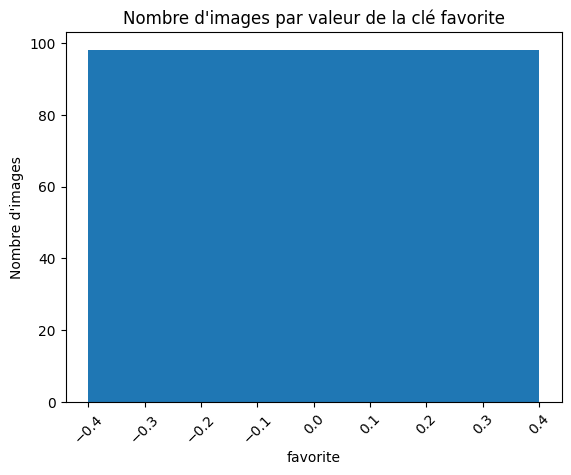

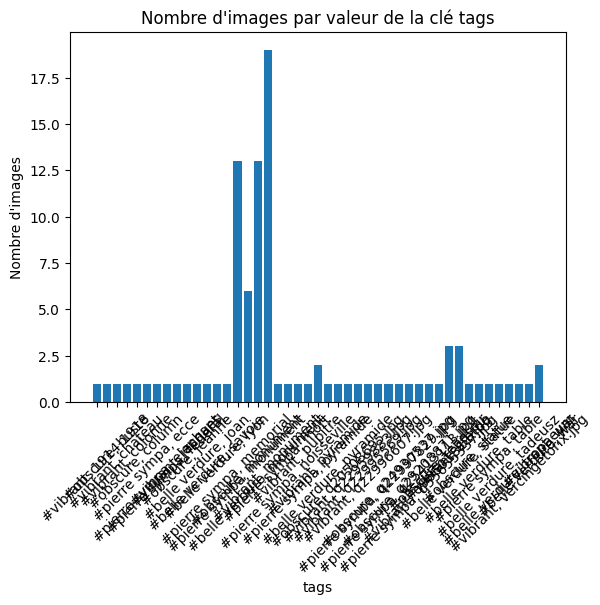

In [5]:
metadata_file = "metadata.json"

# Fonction pour charger les métadonnées à partir d'un fichier JSON
def load_metadata(file_path):
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            return json.load(f)
    else:
        print(f"Le fichier {file_path} n'existe pas.")
        return []

# Fonction pour obtenir le nombre d'images pour chaque valeur de chaque clé dans les métadonnées
def get_image_count():
    images_per_value = {}
    
    for data in metadata:
        for key, value in data.items():
            if isinstance(value, list):
                value = ', '.join(map(str, value))
            images_per_value.setdefault(key, {}).setdefault(value, 0)
            images_per_value[key][value] += 1

    return images_per_value

metadata = load_metadata(metadata_file)

# Extraction du nombre d'images pour chaque valeur de chaque clé
image_counts = get_image_count()

# Création des diagrammes en barres
for key, value_counts in image_counts.items():
    fig, ax = plt.subplots()
    values = list(value_counts.keys())
    counts = list(value_counts.values())
    ax.bar(values, counts)
    ax.set_xlabel(key)
    ax.set_ylabel('Nombre d\'images')
    ax.set_title(f'Nombre d\'images par valeur de la clé {key}')
    plt.xticks(rotation=45)
    plt.show()
    




# **Création des User et choix**

In [16]:
metadata = load_metadata(metadata_file)
nb_user = 3
image_selection = []

files = []
for file in os.listdir("images"):
    files.append(file)
for i in range(nb_user):
    image_selection.append(random.choices(files, k=10))

user_selection = []

# Sélection des index des images choisies par chaque utilisateur dans la liste des fichiers d'images
for i in range(nb_user):
    user_selection.append([])
    for j in range(len(files)): 
        if (files[j] in image_selection[i]):
            user_selection[i].append(j)

print(user_selection)

# Récolte des données des images sélectionnes par utilisateurs
type_data = ["year","hour","couleur1","couleur2","couleur3"]

data = []
cpt = 0

# Parcours des sélections d'images pour chaque utilisateur
for i in range(len(image_selection)):
    data.append([])
    cpt = 0
    for j in user_selection[i]:
        data[i].append([])
        for k in range(len(type_data)):
            data[i][cpt].append(metadata[j][type_data[k]])
        cpt += 1


[[1, 3, 11, 27, 61, 66, 69, 70, 73, 78], [7, 51, 53, 73, 78, 79, 83, 90, 95, 97], [45, 47, 51, 53, 56, 57, 80, 85, 93, 95]]


In [17]:
result = []
dataframe = []
resultframe = []
encoder = []
dtc = []

image_favorite =[]
# Les utilisateurs choisissent leurs images favorites
for k in range(nb_user):
    result.append([])
    dataframe.append([])
    resultframe.append([])
    encoder.append([])
    dtc.append([])
    image_favorite.append([])

    for i in range(len(data[k])):
        if random.randint(0, 1) == 1:
            result[k].append("Favorite")
            image_favorite[k].append([i])
        else:
            result[k].append("NotFavorite")

    # Creation des dataframes
    dataframe[k] = pd.DataFrame(data[k], columns=type_data)
    resultframe[k] = pd.DataFrame(result[k], columns=["favorite"])


    # Encodage des données 
    encoder[k] = [LabelEncoder() for i in range(6)]
    for j in range(len(type_data)):
        dataframe[k][type_data[j]] = encoder[k][j].fit_transform(dataframe[k][type_data[j]])
    resultframe[k]["favorite"] = encoder[k][len(type_data)].fit_transform(resultframe[k]["favorite"])

    # Création des arbres de décision
    dtc[k] = tree.DecisionTreeClassifier()
    dtc[k].fit(dataframe[k].values, resultframe[k]["favorite"])

print(image_favorite)


[[[1], [3], [4], [5], [7], [8]], [[4], [5], [6], [7], [8], [9]], [[0], [1], [3], [4]]]


# **Etablissment des arbres de decision**

Arbre de décision de l'utilisateur 1 :


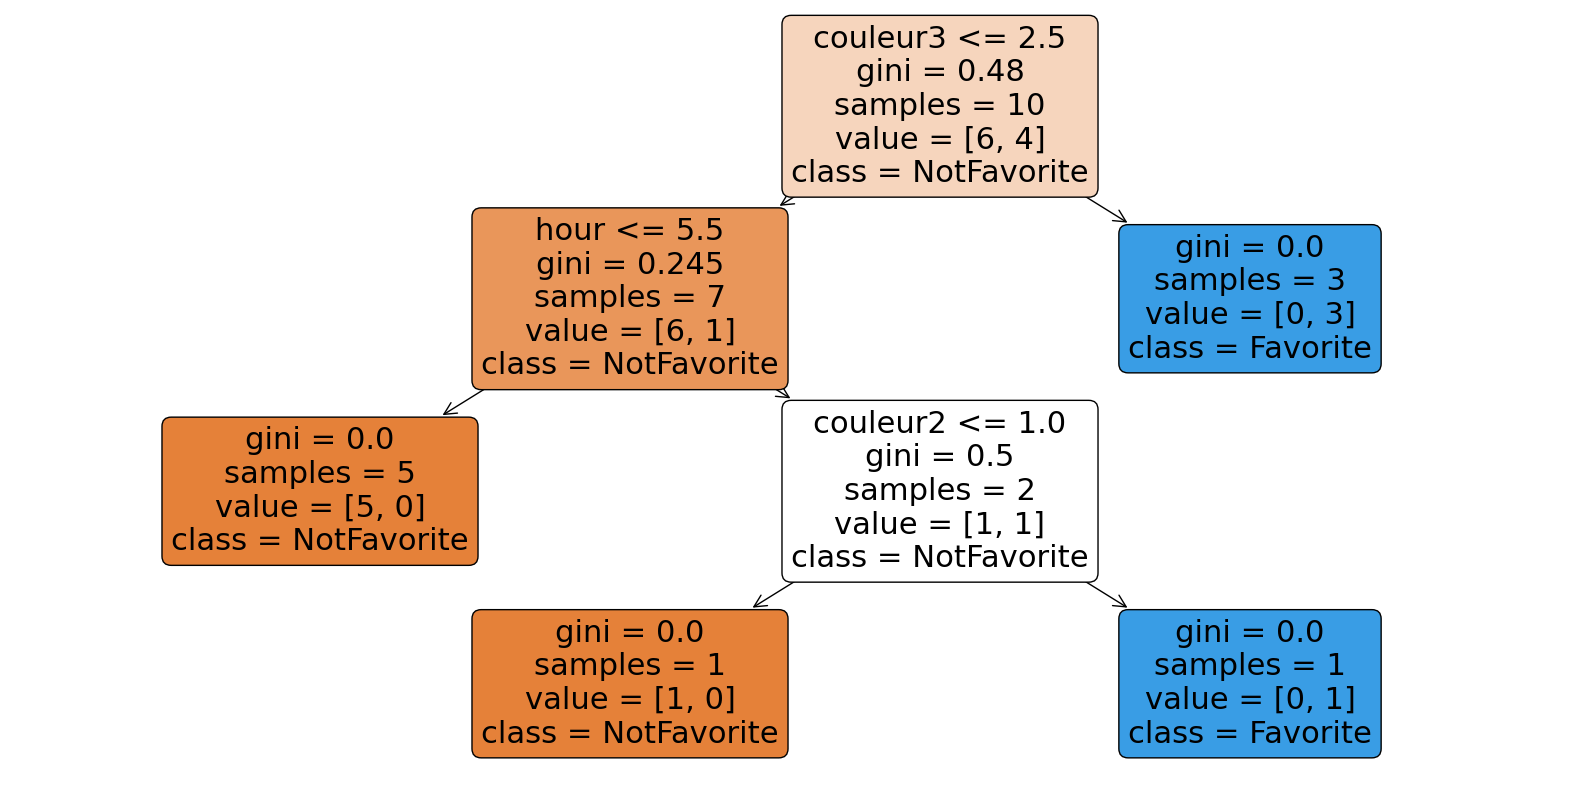

Arbre de décision de l'utilisateur 2 :


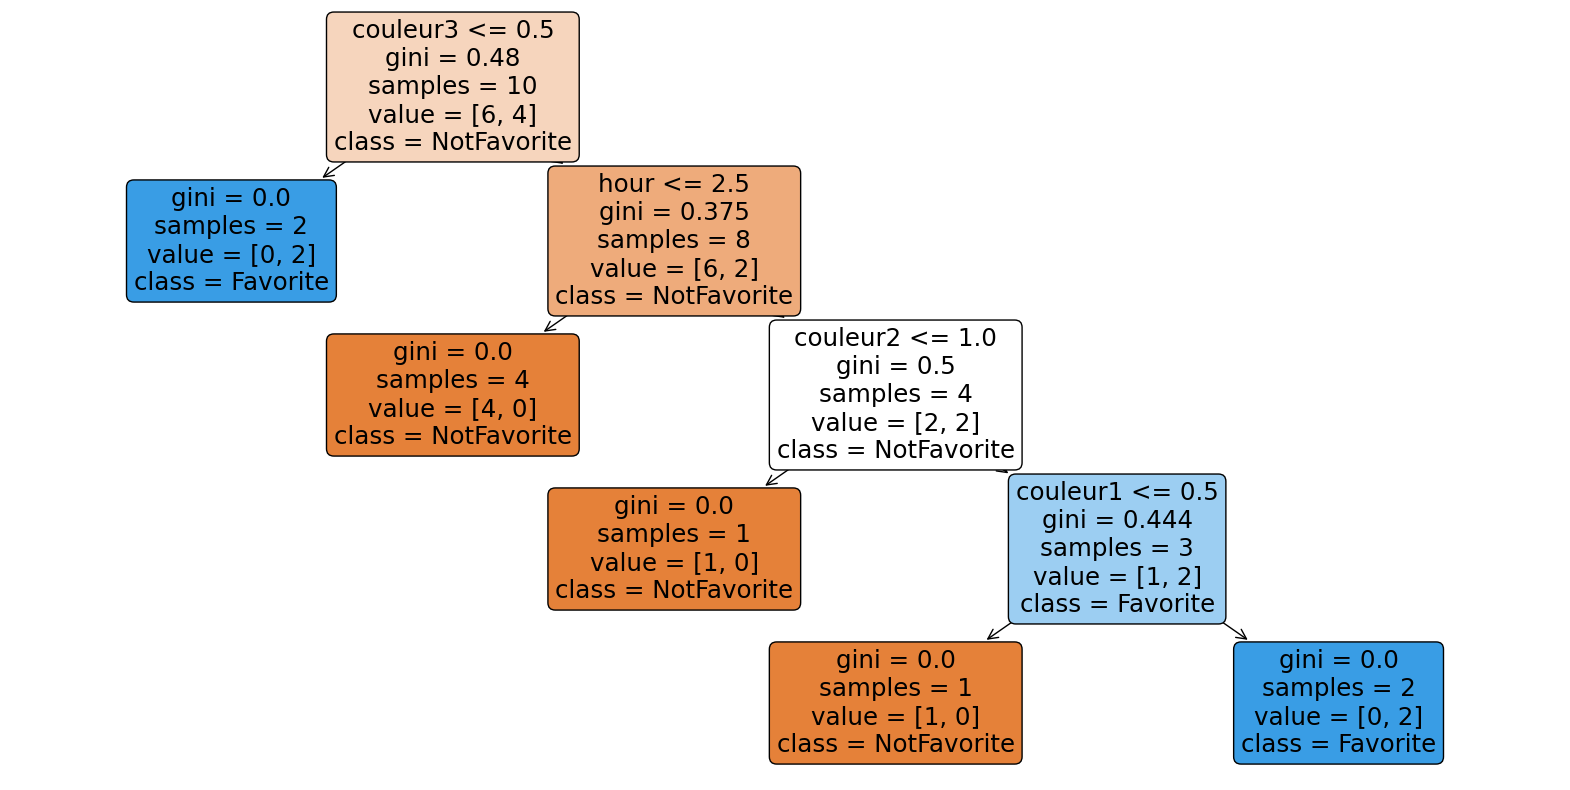

Arbre de décision de l'utilisateur 3 :


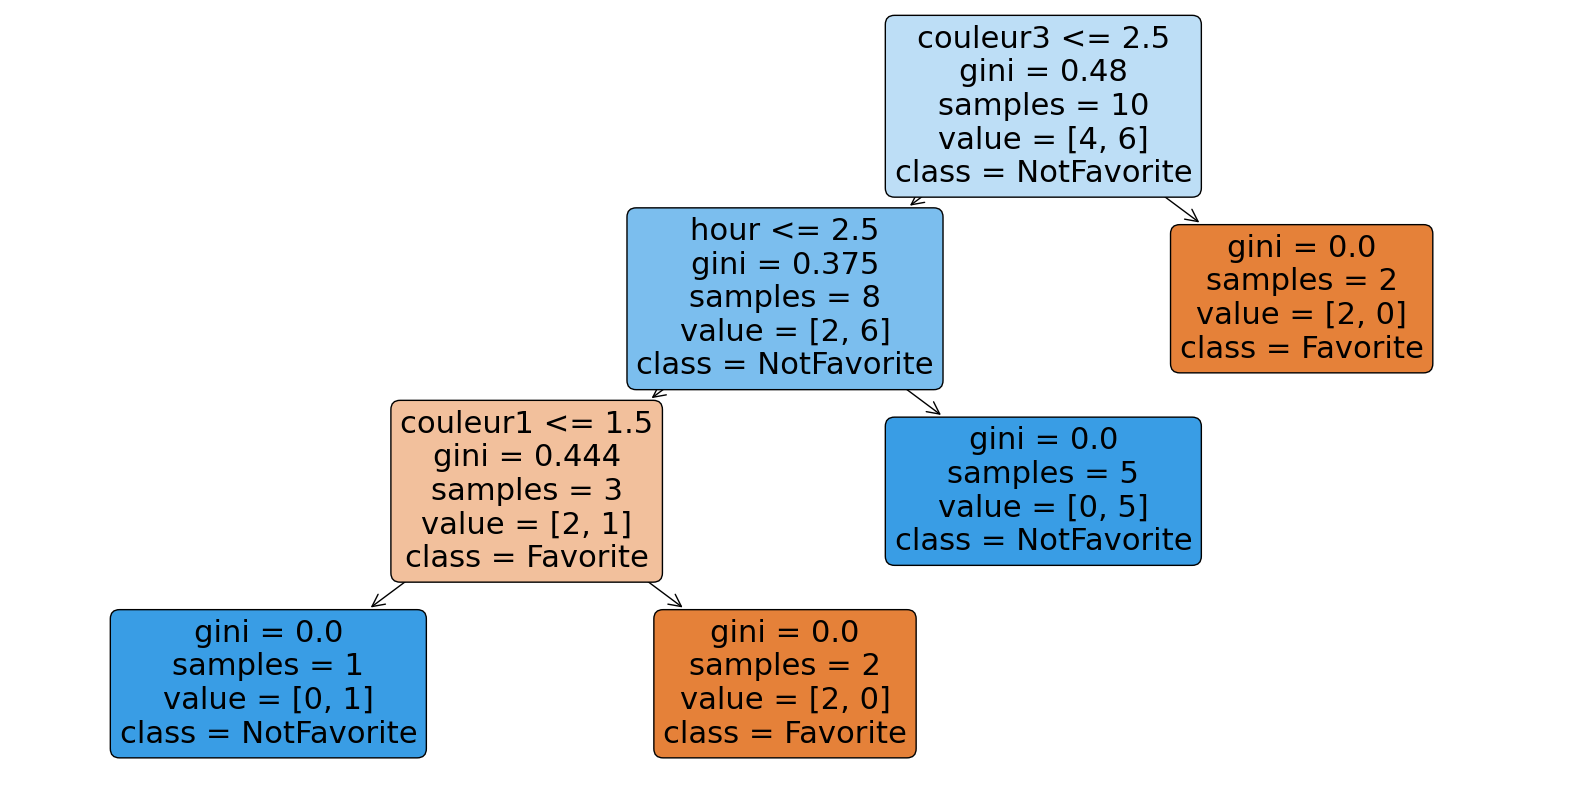

In [18]:
# Visualisation de l'arbre de décision de chaque utilisateur

for k in range(nb_user):
    
    print("Arbre de décision de l'utilisateur " + str(k+1) + " :")
    
    plt.figure(figsize=(20,10))
    plot_tree(dtc[k], 
              feature_names=dataframe[k].columns, 
              class_names=encoder[k][len(type_data)].inverse_transform(resultframe[k].favorite.unique()), 
              filled=True, 
              rounded=True)
    plt.show()


# **Recommandation utilisateur et test**

In [19]:

with open('metadata.json') as fichier:
    metadata = json.load(fichier) 

#Images a recommander
reco = [] 

for k in range(nb_user):
    
    reco.append([])

    for i in range(len(files)):
    
        try:
            # Préparation des données pour la prédiction
            data_to_predict = []
            for j in range(len(type_data)):
                data_to_predict.append(encoder[k][j].transform([metadata[i][type_data[j]]])[0])

            # Prédiction
            prediction = dtc[k].predict([data_to_predict])

            # Vérification si l'image est prédite comme "Favorite"
            if encoder[k][len(type_data)].inverse_transform(prediction)[0] == 'Favorite':
                reco[k].append(i)

        except Exception as e:
            print(f"Erreur lors de la prédiction pour l'image {i}: {str(e)}")
            pass

print(reco)


Erreur lors de la prédiction pour l'image 4: y contains previously unseen labels: '13'
Erreur lors de la prédiction pour l'image 5: y contains previously unseen labels: 'Blanc'
Erreur lors de la prédiction pour l'image 7: y contains previously unseen labels: '2015'
Erreur lors de la prédiction pour l'image 8: y contains previously unseen labels: '16'
Erreur lors de la prédiction pour l'image 9: y contains previously unseen labels: '2010'
Erreur lors de la prédiction pour l'image 10: y contains previously unseen labels: '2010'
Erreur lors de la prédiction pour l'image 12: y contains previously unseen labels: '2015'
Erreur lors de la prédiction pour l'image 13: y contains previously unseen labels: '23'
Erreur lors de la prédiction pour l'image 14: y contains previously unseen labels: '2023'
Erreur lors de la prédiction pour l'image 15: y contains previously unseen labels: '2023'
Erreur lors de la prédiction pour l'image 16: y contains previously unseen labels: '23'
Erreur lors de la préd

# **Affichage des recommandations des Users**

Une image recommendée pour l'utilisateur 1 :
Pyramide de Genille.JPG


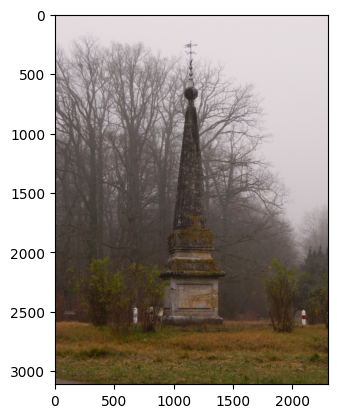

Les images favorites de l'utilisateur 1 :


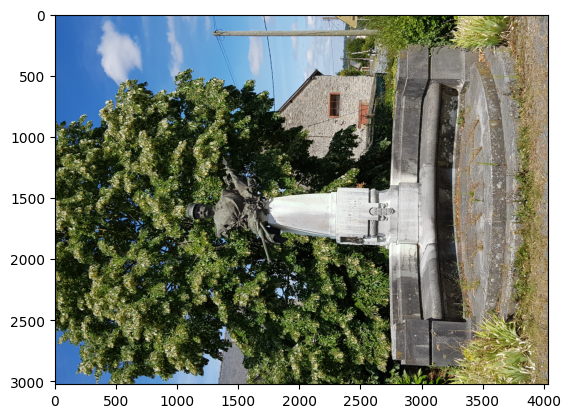

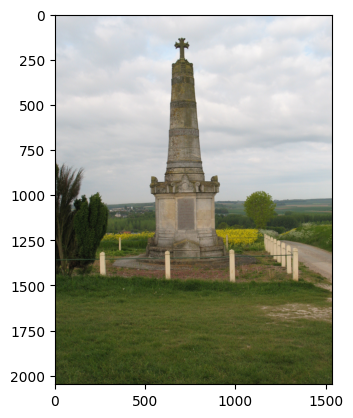

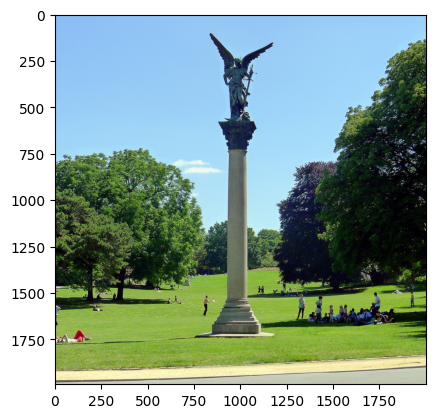

Une image recommendée pour l'utilisateur 2 :
Monument funeraire d'Acelin et Perrenelle de Courciaux.jpg


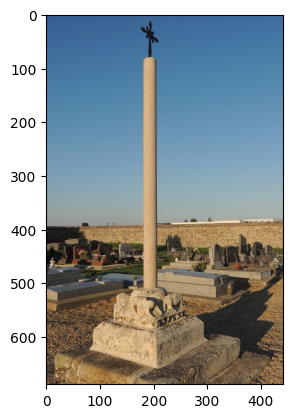

Les images favorites de l'utilisateur 2 :


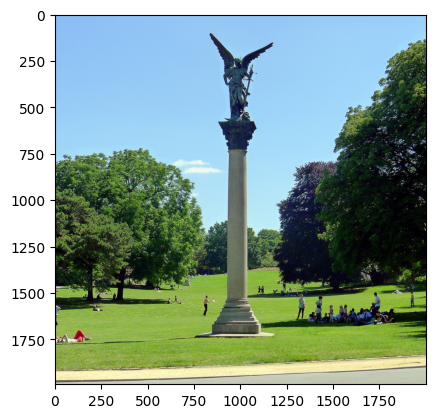

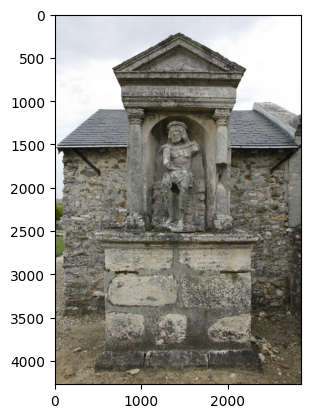

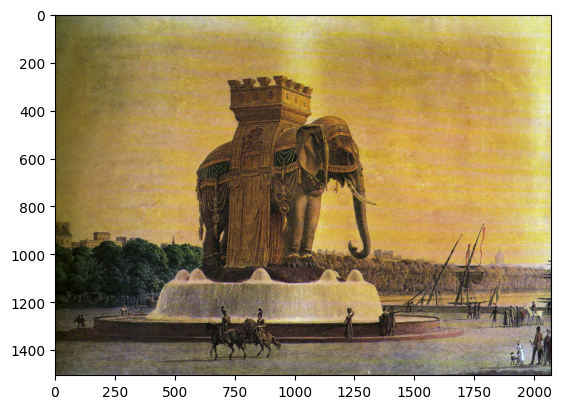

Une image recommendée pour l'utilisateur 3 :
Monument funeraire de Pierre-Victor Loth.jpg


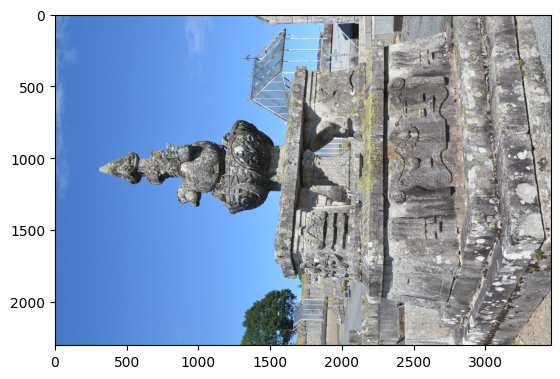

Les images favorites de l'utilisateur 3 :


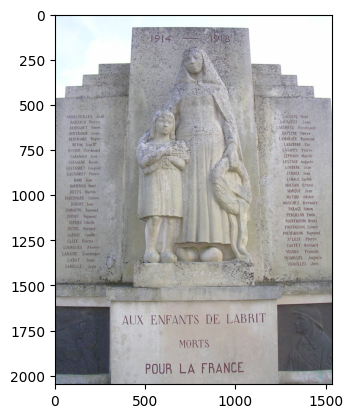

In [20]:
# Fonction pour nettoyer et normaliser les noms de fichiers
def clean_and_normalize_filename(filename):
    # Normaliser les caractères Unicode
    normalized_filename = unicodedata.normalize('NFKD', filename).encode('ASCII', 'ignore').decode('utf-8')
    # Remplacer les caractères non autorisés par des tirets
    cleaned_filename = re.sub(r'[<>:"/\\|?*]', '-', normalized_filename)
    return cleaned_filename

for k in range(nb_user):
    
    if reco[k] != [] :
        
        print("Une image recommendée pour l'utilisateur " + str(k+1) + " :")
        
        choix = random.choice(reco[k])
        # Normaliser le nom de fichier pour eviter les caractére spéciaux
        file_name_normalized = clean_and_normalize_filename(metadata[choix]['file_name'])
        print(file_name_normalized)

        image = mpimg.imread('./images/' + file_name_normalized)
        plt.imshow(image)
        plt.show()
        
        print("Les images favorites de l'utilisateur " + str(k+1) + " :")

        if user_selection[k] !=[]:
            for i in range(len(image_favorite[k][3:])):
                image_index = image_favorite[k][i][0]
                image = mpimg.imread('./images/' + str(metadata[image_index]['file_name']))
                plt.imshow(image)
                plt.show()
          

